In [2]:
# Configuration file to manage API keys as environment variables
from dotenv import load_dotenv
# Load API key information
load_dotenv(override=True)




True

# Evaluation of Response Obtained using the askmcq System

#### Importing required libraries

In [3]:

import os
import json


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from openai import  OpenAI





### Defining Required funcitons all together

We used the given setting to obtain the response of mcq. Since the `ground_truth_context` and `reasoning` was obtained from LLM directly without any expert knowledge, We would assume the LLM to be providing correct answer and is not misinterpreting the things.

In [4]:
from langchain.embeddings import HuggingFaceEmbeddings


# model_name = "abhinand/MedEmbed-small-v0.1"
model_name = "abhinand/MedEmbed-base-v0.1"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

/tmp/ipykernel_174845/2472614287.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=model_name)
/home/anil/miniforge3/envs/RAG/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Function to calculate similarity score

def calculate_similarity(model_context, ground_truth_context):
    # Get embeddings for both texts
    model_embedding = embeddings.embed_query(model_context)
    ground_truth_embedding = embeddings.embed_query(ground_truth_context)
    # Calculate cosine similarity
    similarity = cosine_similarity([model_embedding], [ground_truth_embedding])[0][0]
    return similarity


open.api_key = os.getenv("OPENAI_API_KEY")

# Intialize OpenAI client
client = OpenAI()

# # Function to get embeddings from OpenAI

# def get_embedding(text_to_embed):
# 	# Embed a line of text
# 	response = client.embeddings.create(
#     	model= "text-embedding-3-small",
#     	input=[text_to_embed]
# 	)
# 	# Extract the AI output embedding as a list of floats
# 	embedding = response.data[0].embedding
    
# 	return embedding

# # Function to calculate context similarity

# def calculate_similarity(model_context, ground_truth_context):
#     model_embedding = get_embedding(model_context)
#     ground_truth_embedding = get_embedding(ground_truth_context)
#     similarity = cosine_similarity([model_embedding], [ground_truth_embedding])[0][0]
#     return similarity


In [8]:
# function to return similarty score of groutn truth and model context and reasoning and resoning ground truth


def evaluate_similairty(response_df):



    df = response_df.copy()
    # Calculate similarity scores
    df["Context Similarity"] = df.apply(
        lambda row: calculate_similarity(row["context"], row["ground_truth_context"]), axis=1
    )
    df["Reasoning Quality"] = df.apply(
        lambda row: calculate_similarity(row["model_reasoning"], row["reasoning_ground_truth"]), axis=1
    )

    # Select relevant columns for the result
    result_df = df[["Context Similarity", "Reasoning Quality"]]
    return result_df


def plot_scores(df):
    """
    Plot histograms for context similarity and reasoning quality scores.

    Args:
        df (pd.DataFrame): DataFrame with individual scores for context similarity and reasoning quality.
    """

    # Plotting
    plt.figure(figsize=(10, 5))

    # Histogram for scores
    plt.subplot(1, 2, 1)
    sns.histplot(df, bins=15, kde=True)
    plt.title("Distribution of Scores")
    plt.xlabel("Scores")
    plt.ylabel("Frequency")

    # Scatter plot for context vs reasoning
    plt.subplot(1, 2, 2)
    sns.scatterplot(x="Context Similarity", y="Reasoning Quality", data=df)
    plt.title("Context Similarity vs Reasoning Quality")
    plt.xlabel("Context Similarity")
    plt.ylabel("Reasoning Quality")

    plt.tight_layout()
    plt.show()


def evaluate_accuracy(df):
    
    # Ensure required columns exist
    required_columns = {'correct_answer_idx', 'model_answer_idx'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns in DataFrame: {required_columns - set(df.columns)}")

    # Filter valid rows where predictions and ground truth exist
    valid_df = df.dropna(subset=['correct_answer_idx', 'model_answer_idx'])

    # Extract true and predicted labels
    y_true = valid_df['correct_answer_idx'].astype(int)
    y_pred = valid_df['model_answer_idx'].astype(int)

    # Compute accuracy
    total = len(valid_df)
    correct = (y_true == y_pred).sum()
    accuracy = correct / total if total > 0 else 0

    # Compute confusion matrix
    labels = sorted(set(y_true) | set(y_pred))  # Use all possible labels from data
    confusion = confusion_matrix(y_true, y_pred, labels=labels)
    confusion_df = pd.DataFrame(
        confusion,
        index=[f"True {chr(65 + i)}" for i in labels],  # Map 0, 1, 2, 3 -> True A, B, C, D
        columns=[f"Pred {chr(65 + i)}" for i in labels]
    )

    return {
        "accuracy": accuracy,
        "total": total,
        "correct": correct,
        "confusion_matrix": confusion_df.to_dict()
    }

def visualize_metrics(metrics):

    # Extracting evaluation metrics
    accuracy = metrics['accuracy']
    total = metrics['total']
    correct = metrics['correct']
    
    # Displaying the metrics as text
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Total Samples: {total}")
    print(f"Correct Predictions: {correct}")
    
    # Convert confusion matrix to DataFrame
    confusion_df = pd.DataFrame.from_dict(metrics['confusion_matrix'])
    
    # Plotting the confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()




## Model:gpt-4o-mini with embeedings `medembed-base` and improved Context 

In [35]:
df_gpt_sim_context = pd.read_json('../outputs/gpt4omini_medembed_similarity_contextimproved.json')
df_gpt_sim_context_similarity = evaluate_similairty(df_gpt_sim_context)
df_gpt_sim_context_accuracy_score = evaluate_accuracy(df_gpt_sim_context)

Accuracy: 0.93
Total Samples: 80
Correct Predictions: 74


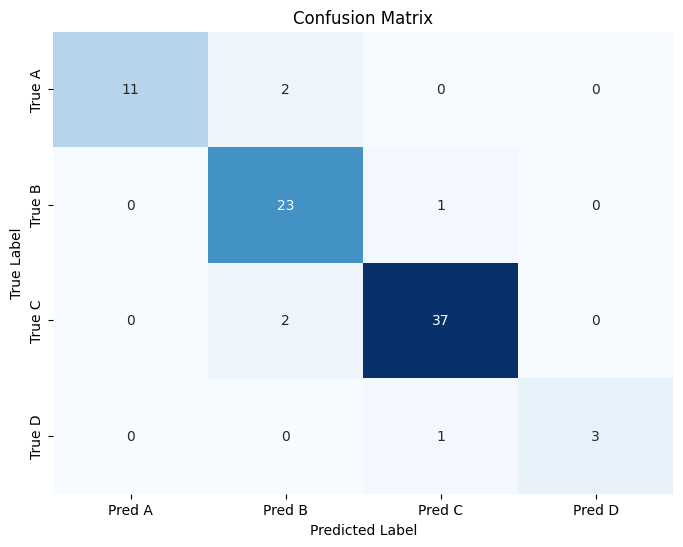

In [37]:
visualize_metrics(df_gpt_sim_context_accuracy_score)

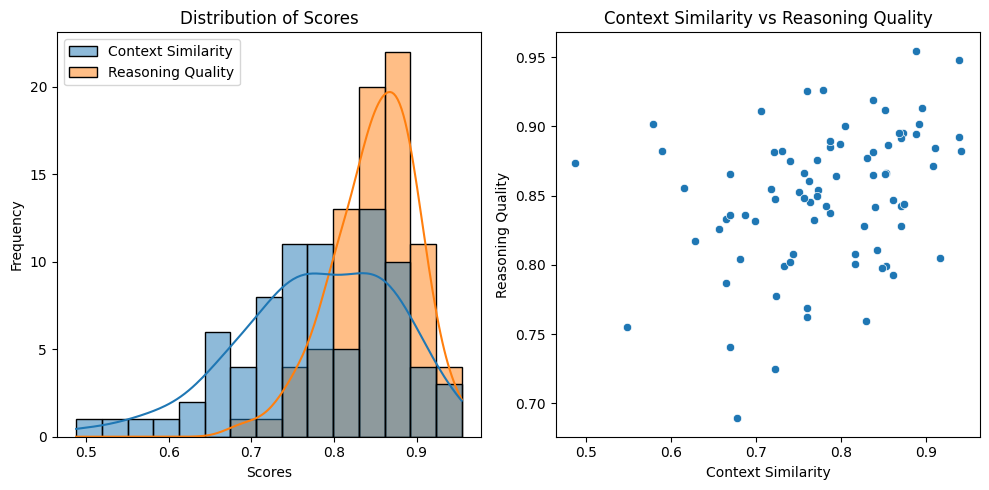

In [38]:
plot_scores(df_gpt_sim_context_similarity)

## Model:gpt-4o-mini with embeedings `medembed-base` similarity search

In [21]:
df_temp = pd.read_json('../gpt4omini_medembed_similarity_search.json')
df_temp_similarity_score = evaluate_similairty(df_temp)
df_temp_accuracy_score = evaluate_accuracy(df_temp)

Accuracy: 0.90
Total Samples: 81
Correct Predictions: 73


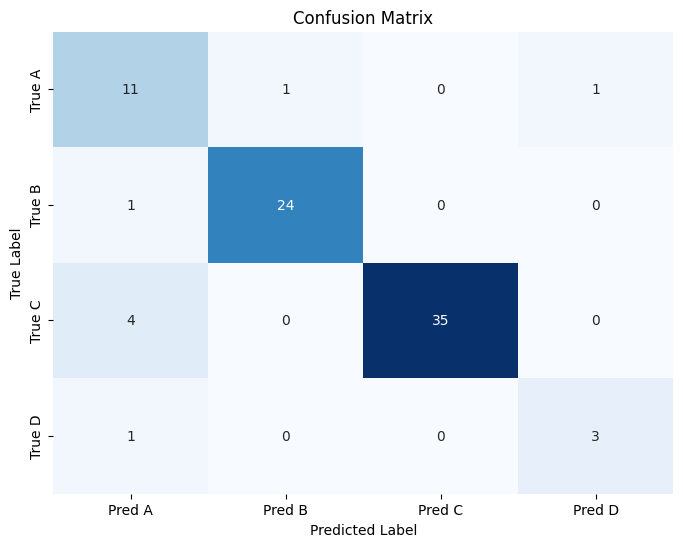

In [26]:
visualize_metrics(df_temp_accuracy_score)

In [34]:
plot_scores(df_temp_similarity_score)

NameError: name 'df_temp_similarity_score' is not defined

## Model gpt-4o with embeedings `medembed-base`, retreiver: `similarity_search`

In [35]:
df_temp = pd.read_json('../outputs/gpt4o_medembed_similarity_search.json')
df_temp_similarity_score = evaluate_similairty(df_temp)
df_temp_accuracy_score = evaluate_accuracy(df_temp)

Accuracy: 0.91
Total Samples: 77
Correct Predictions: 70


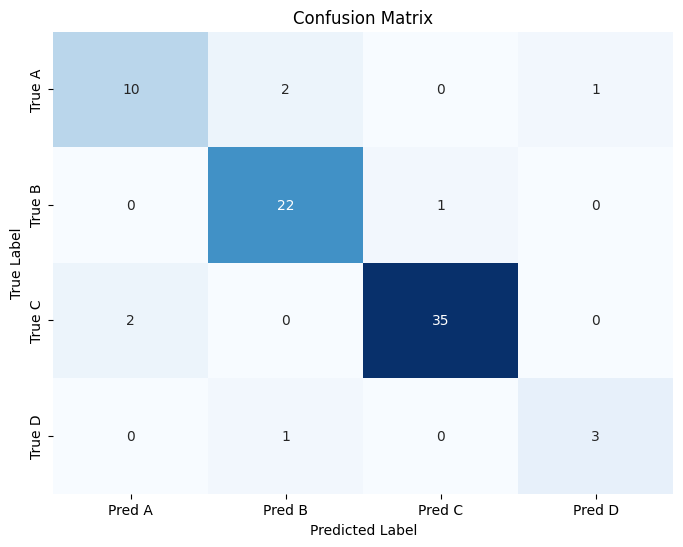

In [36]:
visualize_metrics(df_temp_accuracy_score)

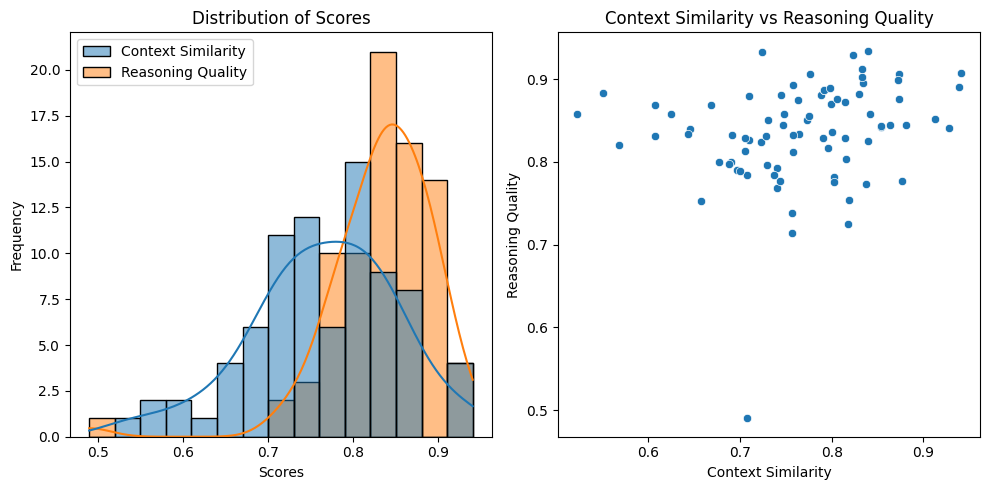

In [38]:
plot_scores(df_temp_similarity_score)


## Model:gpt-4o with embeedings `medembed-base`, retreiver: `reranking`

In [44]:
df_gpt4o_ranking = pd.read_json('../outputs/gpt4o_medembed_reranking.json')
df_gpt4o_ranking_similarity = evaluate_similairty(df_gpt4o_ranking)
df_gpt4o_ranking_score = evaluate_accuracy(df_gpt4o_ranking)

Accuracy: 0.90
Total Samples: 80
Correct Predictions: 72


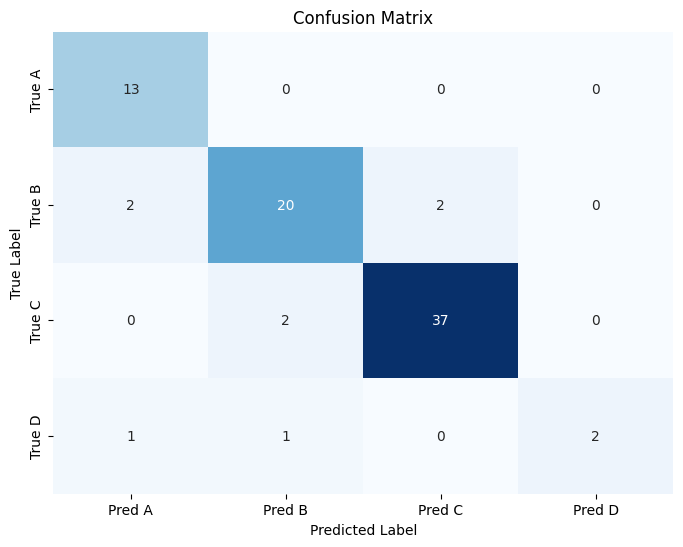

In [45]:
visualize_metrics(df_gpt4o_ranking_score)


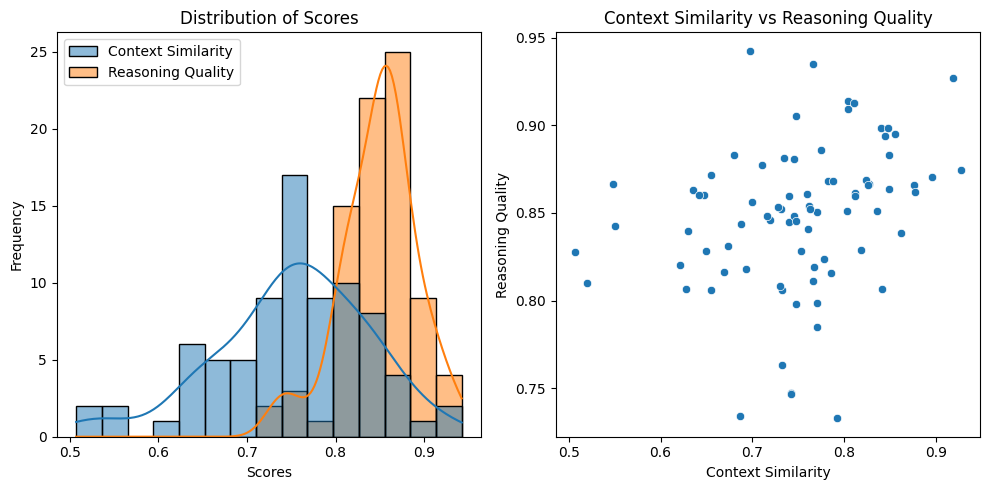

In [46]:
plot_scores(df_gpt4o_ranking_similarity)


## Evaluating Response from Model:gpt-4omini with embeedings `medembed-base`, Chain of Thought with Self Consistency

In [10]:
df_gpt4omini_medembed_cot = pd.read_json('../cot_try.json')
# df_gpt4omini_medembed_cot_similarity = evaluate_similairty(df_gpt4o_openaiembed_similarity)
df_gpt4omini_medembed_cot_score = evaluate_accuracy(df_gpt4omini_medembed_cot)

Accuracy: 0.86
Total Samples: 81
Correct Predictions: 70


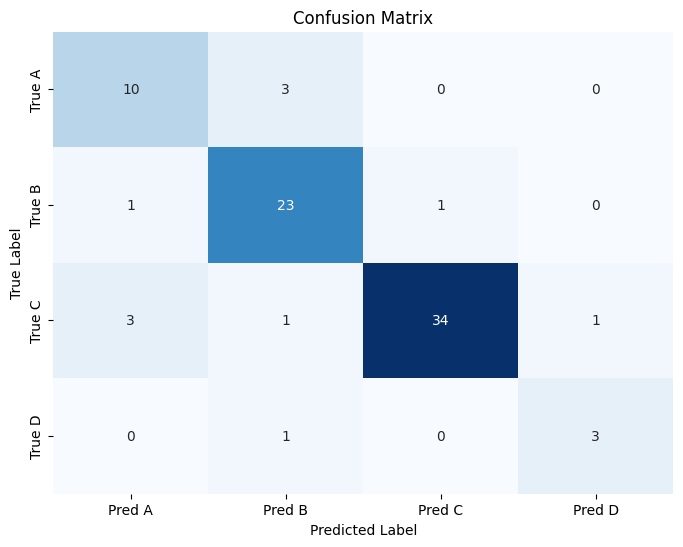

In [11]:
visualize_metrics(df_gpt4omini_medembed_cot_score)

In [28]:
temp = df_gpt4omini_medembed_cot[~(df_gpt4omini_medembed_cot['correct_answer_idx'] == df_gpt4omini_medembed_cot['model_answer_idx'])]
temp.to_json('../cot_try_wrongs.json', orient='records',indent=4)

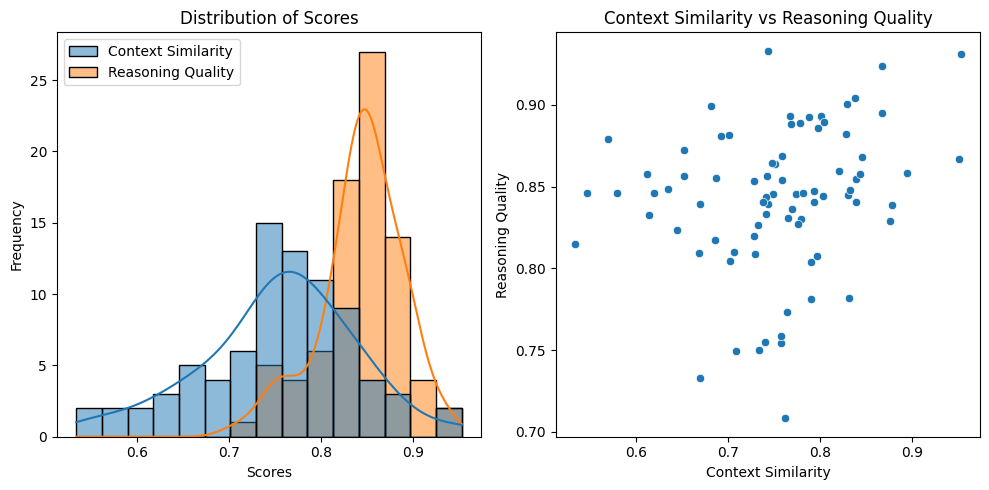

In [ ]:
plot_scores(df_gpt4omini_medembed_cot_similarity)

## Model:gpt-4o with embeedings `openai-text-small-3`, retreiver: `similarity`

In [47]:
df_gpt4o_openaiembed_similarity = pd.read_json('../outputs/gpt4o_openaiembed_similarity.json')
df_gpt4o_openaiembed_similarity_similarity = evaluate_similairty(df_gpt4o_openaiembed_similarity)
df_gpt4o_openaiembed_similarity_score = evaluate_accuracy(df_gpt4o_openaiembed_similarity)

Accuracy: 0.87
Total Samples: 78
Correct Predictions: 68


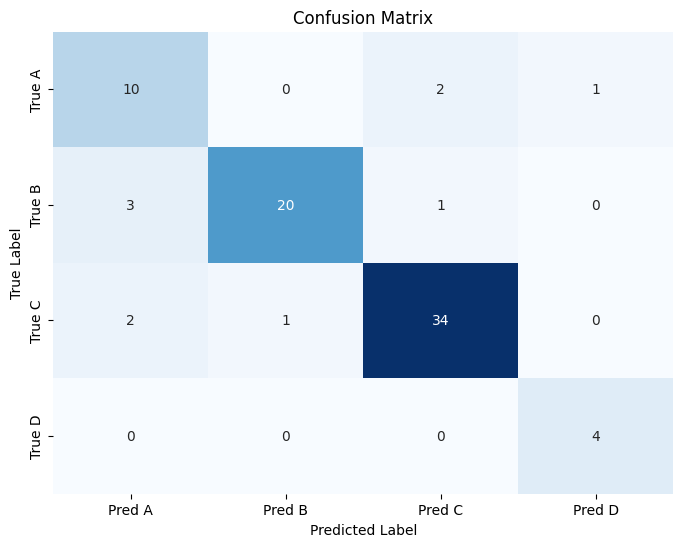

In [48]:
visualize_metrics(df_gpt4o_openaiembed_similarity_score)

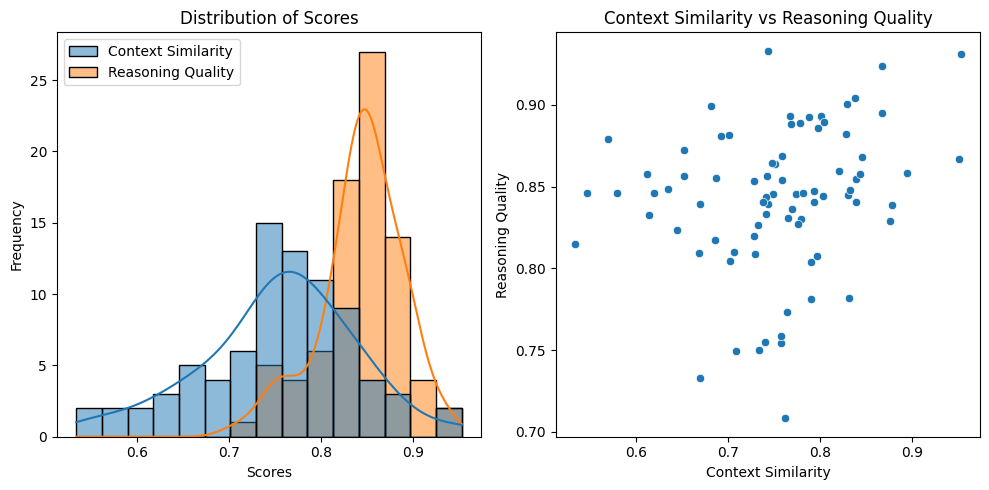

In [49]:
plot_scores(df_gpt4o_openaiembed_similarity_similarity)

In [39]:
#temporary
temp = pd.read_json('../cot_try_improved_context.json')
# tempsimilarity = evaluate_similairty(temp)
temp_accuracy_score = evaluate_accuracy(temp)

Accuracy: 0.88
Total Samples: 80
Correct Predictions: 70


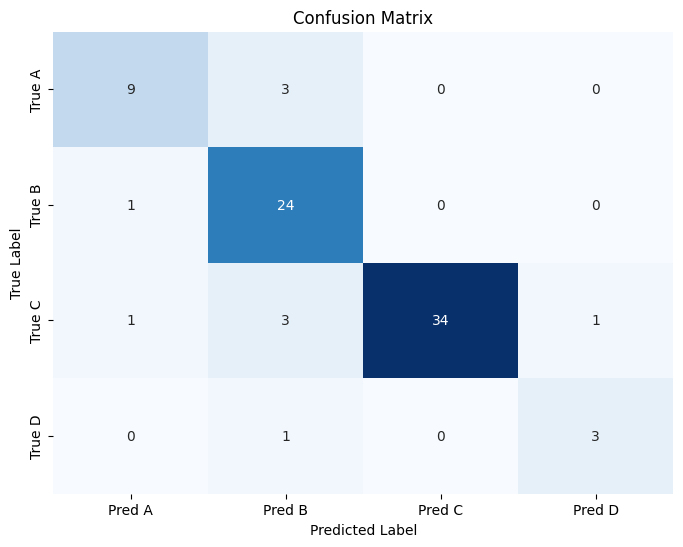

In [40]:
visualize_metrics(temp_accuracy_score)